In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import ViTImageProcessor, ViTModel
from sklearn.decomposition import PCA
from tqdm import tqdm
import os
import requests
from PIL import Image
import io

/Users/mglambert/Documents/PhD/Courses/RecSys/RecSysProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mglambert/Documents/PhD/Courses/RecSys/RecSysProject/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_games = pd.read_csv('../data/df_games_train.csv')
df_games.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,mask
0,42,Tigris & Euphrates,regard reiner knizia masterpiece tigris amp eu...,1997,3.5064,7.69599,7.52665,1.48238,2,4,...,21926,0,1,0,0,0,0,0,0,True
1,45,Perudo,liars dice aka bluff perudo dudo south america...,1800,1.2625,6.90371,6.72095,1.40634,2,6,...,21926,0,0,0,1,0,0,1,0,True
2,50,Lost Cities,lose city card game kosmos twoplayer series ga...,1999,1.4921,7.18784,7.08937,1.26552,2,2,...,21926,0,0,0,1,0,0,0,0,True
3,84,Rommel in the Desert,rommel desert fastmoving challenge tense playa...,1982,3.4183,7.54678,6.24443,1.43983,2,2,...,21926,0,0,1,0,0,0,0,0,True
4,88,Torres,torre abstract game resource management tactic...,1999,2.8656,7.10972,6.82406,1.27896,2,4,...,21926,0,1,0,0,0,1,0,0,True


In [3]:
df_games.loc[0, 'Description']

'regard reiner knizia masterpiece tigris amp euphrates set ancient fertile crescent player build civilization tile placement player give different leader farm trading religion government leader collect victory point category score end game number point weak category encourage player overly specialized conflict arise civilization connect board ie external conflict leader type survive conflict leader replace civilization internal conflictsstarting mayfair edition   tigris amp euphrate include doublesided game board extra component play advanced version game quotziggurat expansionquot initially release separate item germany own base game special monument extend space board monument build player cross civilization token color discard token replace ziggurat marker place ziggurat tower middle tile ziggurat marker destroy rule monument apply ziggurat monument king inside kingdom ziggurat victory point color choice end turnsome version tigris amp euphrate list   player incorrectly state   play

# 1. Procesar descripciones

In [4]:
model_name = "google-bert/bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


def get_embeddings(textos: list, model, tokenizer):
    inputs = tokenizer(textos, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']

    mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
    sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)

    mean_pooled_embeddings = sum_embeddings / sum_mask

    return mean_pooled_embeddings


In [5]:
descriptions = df_games['Description'].tolist()
descriptions[0]

'regard reiner knizia masterpiece tigris amp euphrates set ancient fertile crescent player build civilization tile placement player give different leader farm trading religion government leader collect victory point category score end game number point weak category encourage player overly specialized conflict arise civilization connect board ie external conflict leader type survive conflict leader replace civilization internal conflictsstarting mayfair edition   tigris amp euphrate include doublesided game board extra component play advanced version game quotziggurat expansionquot initially release separate item germany own base game special monument extend space board monument build player cross civilization token color discard token replace ziggurat marker place ziggurat tower middle tile ziggurat marker destroy rule monument apply ziggurat monument king inside kingdom ziggurat victory point color choice end turnsome version tigris amp euphrate list   player incorrectly state   play

In [6]:
embeddings = get_embeddings(descriptions, model, tokenizer)
embeddings.shape

torch.Size([578, 768])

In [7]:

pca = PCA(n_components=15)
embeddings = pca.fit_transform(embeddings)
embeddings.shape


(578, 15)

In [8]:
df_games['Description_embedding'] = [emb.tolist() for emb in embeddings]

# 2. Caraturas

In [9]:
im_path = '../data/images'

if not os.path.exists(im_path):
    os.makedirs(im_path)
    print(f"Directorio '{im_path}' creado.")

for i, row in tqdm(df_games[['ImagePath', 'BGGId']].iterrows()):
    url = row['ImagePath']
    filename = f'{row["BGGId"]}.png'
    try:
        response = requests.get(url, timeout=100)

        if response.status_code == 200:
            file_path = os.path.join(im_path, filename)

            bytes_imagen = io.BytesIO(response.content)
            imagen = Image.open(bytes_imagen)
            imagen.save(file_path, 'PNG')

        else:
            print(f"❌ {response.status_code}\n")

    except requests.exceptions.RequestException as e:
        print(f"❌ {url} \n {e}\n")

print("Done")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
578it [02:26,  3.93it/s]

Done


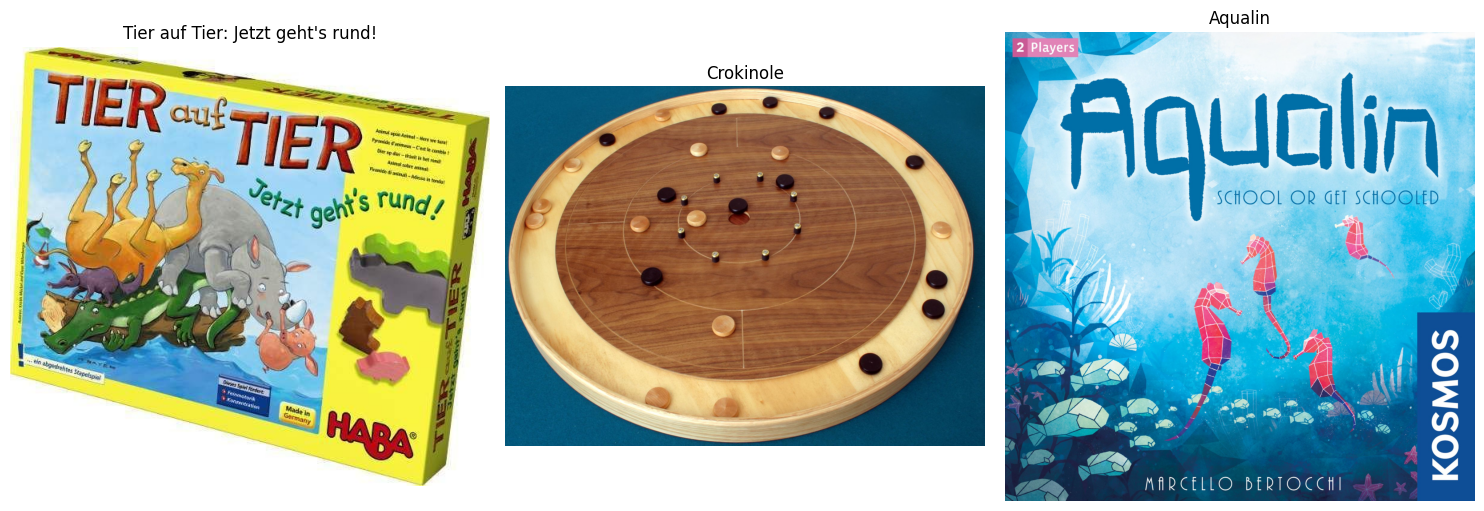

In [10]:
idxs = df_games.BGGId.to_list()

idx1 = int(np.random.choice(idxs))
idx2 = int(np.random.choice(idxs))
idx3 = int(np.random.choice(idxs))
im1 = plt.imread(f'{im_path}/{idx1}.png')
im2 = plt.imread(f'{im_path}/{idx2}.png')
im3 = plt.imread(f'{im_path}/{idx3}.png')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(im1)
ax[0].set_title(df_games.loc[df_games.BGGId==idx1, 'Name'].values[0])
ax[0].axis('off')
ax[1].imshow(im2)
ax[1].set_title(df_games.loc[df_games.BGGId==idx2, 'Name'].values[0])
ax[1].axis('off')
ax[2].imshow(im3)
ax[2].set_title(df_games.loc[df_games.BGGId==idx3, 'Name'].values[0])
ax[2].axis('off')
plt.tight_layout()
plt.show()



In [11]:
images = [Image.open(f'{im_path}/{idx}.png').convert("RGB") for idx in df_games.BGGId]

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

inputs = processor(images=images, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state[:, :, 0].detach().numpy()


/Users/mglambert/Documents/PhD/Courses/RecSys/RecSysProject/.venv/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:
last_hidden_states = PCA(n_components=15).fit_transform(last_hidden_states)

In [13]:
last_hidden_states.shape

(578, 15)

In [14]:
df_games['Image_embedding'] = [emb.tolist() for emb in last_hidden_states]

In [15]:
df_games.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,mask,Description_embedding,Image_embedding
0,42,Tigris & Euphrates,regard reiner knizia masterpiece tigris amp eu...,1997,3.5064,7.69599,7.52665,1.48238,2,4,...,1,0,0,0,0,0,0,True,"[1.6221164078648176, 0.4162736554681593, 0.411...","[-0.027837831526994705, 0.266801118850708, -0...."
1,45,Perudo,liars dice aka bluff perudo dudo south america...,1800,1.2625,6.90371,6.72095,1.40634,2,6,...,0,0,1,0,0,1,0,True,"[-1.9267694786956318, -0.8144234246559084, 0.5...","[2.309972047805786, -0.1461237072944641, 0.051..."
2,50,Lost Cities,lose city card game kosmos twoplayer series ga...,1999,1.4921,7.18784,7.08937,1.26552,2,2,...,0,0,1,0,0,0,0,True,"[2.7072484611295216, -1.2085546881032145, 0.75...","[-0.10191409289836884, -0.17125050723552704, 0..."
3,84,Rommel in the Desert,rommel desert fastmoving challenge tense playa...,1982,3.4183,7.54678,6.24443,1.43983,2,2,...,0,1,0,0,0,0,0,True,"[2.0997226904405784, 0.28591152242846124, -0.0...","[1.1813172101974487, -0.09463532269001007, 0.3..."
4,88,Torres,torre abstract game resource management tactic...,1999,2.8656,7.10972,6.82406,1.27896,2,4,...,1,0,0,0,1,0,0,True,"[-2.6206971568635415, -0.6790494237723477, -1....","[1.732688546180725, 0.19650126993656158, -0.33..."


# Save

In [16]:
df_games.to_csv('../data/df_games_train.csv', index=False)